In [1]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

In [2]:
# import datasets

#train = pd.read_csv('../input/train.csv')
train = pd.read_csv('../data/kaggle household poverty/train.csv')

#test = pd.read_csv('../input/test.csv')
test = pd.read_csv('../data/kaggle household poverty/test.csv')

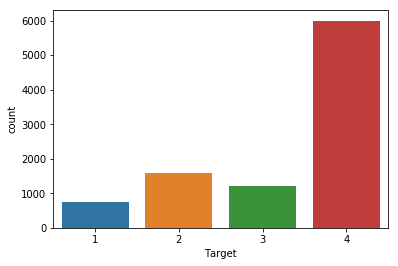

In [3]:
# extract target variable from train set
target = train['Target']
del train['Target']

# view the distribution of the target variable
sns.countplot(target) # target variable has imbalanced classes; use balanced class weights when building random forest later

# extract Id variable from test set
Id = test['Id']

In [4]:
# bind the rows of the train and test sets
full = pd.concat([train,test], axis='rows')

# drop unwanted variables
full.drop(columns=['Id','parentesco1'], inplace=True)

In [5]:
# correct outlier(s)
full.loc[full['rez_esc'] == 99.0 , 'rez_esc'] = 5

In [6]:
# check for missing values
print(full.isnull().any().describe()) # 139-134=5 variables have missing values
print('-'*50)

full_na = full.isnull().sum().values / full.shape[0] *100
full_na = pd.DataFrame(full_na, index=full.columns, columns=['Count'])
full_na = full_na.sort_values(by=['Count'], ascending=False)
full_na = full_na[full_na['Count']>0]
print(full_na)

count       140
unique        2
top       False
freq        135
dtype: object
--------------------------------------------------
               Count
rez_esc    82.545716
v18q1      76.221830
v2a1       72.615449
SQBmeaned   0.107742
meaneduc    0.107742


In [7]:
# figure out how missing values should be imputed (for variables with lots of missing values)
print(full['rez_esc'].value_counts())
print(full[['escolari','rez_esc']].head()) # can fill with median
print('-'*50)

print(full['v18q1'].value_counts())
print(full[['v18q1','v18q']].head()) # fill with zero
print('-'*50)

print(full[['v2a1','tipovivi3']].sort_values('tipovivi3')) # fill with zero

0.0    4474
1.0     728
2.0     336
3.0     174
4.0      80
5.0      40
Name: rez_esc, dtype: int64
   escolari  rez_esc
0        10      NaN
1        12      NaN
2        11      NaN
3         9      1.0
4        11      NaN
--------------------------------------------------
1.0    5883
2.0    1449
3.0     447
4.0     125
5.0      31
6.0      10
Name: v18q1, dtype: int64
   v18q1  v18q
0    NaN     0
1    1.0     1
2    NaN     0
3    1.0     1
4    1.0     1
--------------------------------------------------
           v2a1  tipovivi3
23855       NaN          0
20087       NaN          0
20088       NaN          0
20089       NaN          0
20090       NaN          0
20091       NaN          0
20092       NaN          0
20093       NaN          0
9321        NaN          0
9320        NaN          0
9319        NaN          0
9318        NaN          0
9317        NaN          0
9316        NaN          0
9315        NaN          0
20094       NaN          0
20095       NaN          

In [8]:
# customized imputation of missing values
full['v18q1'] = full['v18q1'].fillna(0)

full['v2a1'] = full['v2a1'].fillna(0)

# create list of numeric variables with missing values
numeric_cols_with_missing = [] # initialize empty list

for col, col_data in full.iteritems():
    if col_data.isnull().any() and (col_data.dtype=='int' or col_data.dtype=='float'):
        numeric_cols_with_missing.append(col)

# impute numeric variables' missing values with variable medians
for var in numeric_cols_with_missing:
    full[var].fillna(full[var].median(), inplace = True)

# create list of object variables with missing values
object_cols_with_missing = []

for col, col_data in full.iteritems():
    if col_data.isnull().any() and col_data.dtype=='object':
        object_cols_with_missing.append(col)

# impute object variables' missing values with variable modes
for var in object_cols_with_missing:
    full[var].fillna(full[var].mode()[0], inplace = True)

# confirm that there are no more missing values
full.isnull().any().describe()

count       140
unique        1
top       False
freq        140
dtype: object

In [9]:
# view string variables (except idhogar)
object_cols = []

for col, col_data in full.iteritems():
    if col_data.dtype=='object' and col!='idhogar':
        object_cols.append(col)

for object_col in object_cols:
    print(full[object_col].value_counts())
    print('-'*50)

# string variables can be converted to numeric; recode 'yes' to 1, and 'no' to 0
full[object_cols] = full[object_cols].replace({'no':0, 'yes':1}).astype(float)

yes          7580
no           6036
.5           5175
2            2499
1.5          2471
.33333334    2131
.66666669    1617
8            1415
.25           944
3             832
1.3333334     362
.2            306
.75           301
2.5           301
4             295
.40000001     259
.60000002     136
1.6666666     128
5             120
1.25           72
.80000001      63
.16666667      63
3.5            36
.83333331      33
.14285715      32
2.3333333      30
2.25           26
1.2            22
.2857143       18
7              16
6              14
.85714287      13
3.3333333      13
.71428573      12
.22222222      11
.375           11
1.75           11
.125            9
Name: dependency, dtype: int64
--------------------------------------------------
no     12818
6       6958
11      2507
9       1564
3       1046
8       1020
15       910
14       804
7        797
17       702
5        685
2        617
16       609
4        505
12       494
yes      416
10       395
13       341


In [10]:
# confirm that there are no more string variables (except idhogar)
print(full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33413 entries, 0 to 23855
Columns: 140 entries, v2a1 to agesq
dtypes: float64(11), int64(128), object(1)
memory usage: 35.9+ MB
None


In [11]:
# feature engineering
full['mean_overcrowding'] = full[['hacdor','hacapo']].mean(axis=1)

full['under12_12andover'] = full['r4t1'] / full['r4t2']

full_groupby_idhogar = pd.DataFrame()
important_features = ['escolari','age']
for feat in important_features:
    for func in ['mean','min','max']:
        newcol = feat + '_' + func
        full_groupby_idhogar[newcol] = full.groupby('idhogar')[feat].agg(func)
full_groupby_idhogar = full_groupby_idhogar.reset_index()
full = full.merge(full_groupby_idhogar, on='idhogar')
del full_groupby_idhogar

In [12]:
# drop idhogar
del full['idhogar']

# split full dataset into train and test sets
train = full[:train.shape[0]]
test = full[train.shape[0]:]

In [13]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# initialize a template for random forest, based on the parameters you want to set
rfc = RandomForestClassifier(n_jobs=-1,
                             n_estimators=200,
                             class_weight='balanced',
                             max_depth=7)

# perform cross-validation
rfc_cv = model_selection.cross_validate(rfc,
                                        train,
                                        target,
                                        scoring='f1_macro',
                                        cv=10)

print('the mean training macro F1 score is:', rfc_cv['train_score'].mean())
print('the mean cross-validation macro F1 score is:', rfc_cv['test_score'].mean())

the mean training macro F1 score is: 0.6979140734400259
the mean cross-validation macro F1 score is: 0.4045766689314275


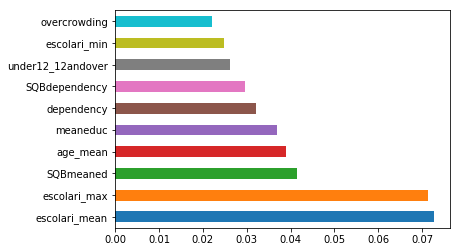

In [14]:
# fit the random forest
rfc_fitted = rfc.fit(train,target)

# plot feature importance (as determined by the built random forest model)
feature_importances = pd.Series(rfc_fitted.feature_importances_, index=train.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance
feature_importances.nlargest(10).plot(kind='barh')

In [15]:
# generate predictions for the test set
predictions_rfc = rfc_fitted.predict(test)
predictions_rfc = predictions_rfc.astype('int')

submission_rfc = pd.DataFrame({'Id': Id,
                               'Target': predictions_rfc})
submission_rfc.to_csv("submission1.csv", index=False)

In [16]:
# let's check if the model is overpredicting the majority class
print(submission_rfc['Target'].value_counts() / submission_rfc.shape[0])
print('-'*50)
print(pd.Series(target).value_counts() / train.shape[0])

4    0.513749
3    0.217052
2    0.160211
1    0.108987
Name: Target, dtype: float64
--------------------------------------------------
4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64
